In [ ]:
import numpy as np
import cv2
import os
import zipfile
from PIL import Image
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install requests

In [ ]:
# Definir o endereço para baixar arquivo
!wget -P /content/drive/MyDrive/ELT579/Problema4 https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip


--2023-11-30 19:49:40--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 108.138.94.6, 108.138.94.36, 108.138.94.100, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|108.138.94.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘/content/drive/MyDrive/ELT579/Problema4/cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  41.4MB/s    in 7.0s    

2023-11-30 19:49:48 (48.1 MB/s) - ‘/content/drive/MyDrive/ELT579/Problema4/cell_images.zip’ saved [353452851/353452851]



In [ ]:
# Extrair conteúdo dos arquivos comprimidos
local_zip = '/content/drive/MyDrive/ELT579/Problema4/cell_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/ELT579/Problema4')
zip_ref.close()

In [ ]:
pasta = '/content/drive/MyDrive/ELT579/Problema4/cell_images/'

positivas = os.listdir(pasta + 'Parasitized/')

negativas = os.listdir(pasta + 'Uninfected/')

In [ ]:
dataset = list()

label = list()

SIZE = 64

for i, image_name in enumerate(positivas):
  if(image_name.split('.')[1] == 'png'):
    img = cv2.imread(pasta + 'Parasitized/' + image_name)
    img = Image.fromarray(img, 'RGB')
    img = img.resize((SIZE, SIZE))
    dataset.append(np.array(img))
    label.append(1)

for i, image_name in enumerate(negativas):
  if(image_name.split('.')[1] == 'png'):
    img = cv2.imread(pasta + 'Uninfected/' + image_name)
    img = Image.fromarray(img, 'RGB')
    img = img.resize((SIZE, SIZE))
    dataset.append(np.array(img))
    label.append(0)

label =  0
imagem


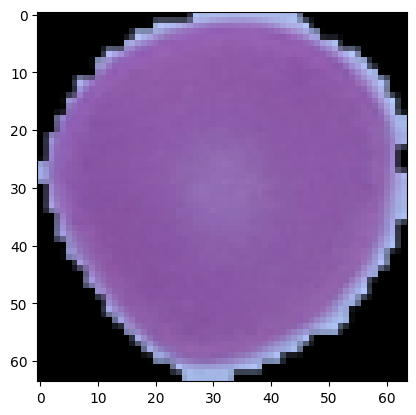

In [ ]:
import matplotlib.pyplot as plt

print('label = ', label[-2])

print('imagem')
plt.imshow(dataset[-2])

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from keras.layers import Lambda, Input
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
import numpy as np
import tensorflow
from tensorflow import keras as K
from sklearn.model_selection import train_test_split

def preprocess_data(X, Y):
    """ This method has the preprocess to train a model """
    X = X.astype('float32')
    X_p = K.applications.vgg16.preprocess_input(X)
    Y_p = K.utils.to_categorical(Y, 2)  # Assuming binary classification, adjust accordingly
    return (X_p, Y_p)

if __name__ == "__main__":
    # Load your custom dataset
    dataset = np.array(dataset)
    label = np.array(label)

    # Divisão dos dados em treinamento, validação e teste

    X_train, X_temp, Y_train, Y_temp = train_test_split(dataset, label, test_size=0.2, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

    # Split the dataset into training and validation sets
    #Xt, X, Yt, Y = train_test_split(dataset, label, test_size=0.2, random_state=42)

    X_train_p, Y_train_p = preprocess_data(X_train, Y_train)
    X_val_p, Y_val_p = preprocess_data(X_val, Y_val)
    X_test_p, Y_test_p = preprocess_data(X_test, Y_test)

    # Now you can use Xt, Yt for training and X, Y for validation
    base_model = K.applications.vgg16.VGG16(include_top=False,
                                            weights='imagenet',
                                            pooling='avg')


In [ ]:
model= K.Sequential()
model.add(K.layers.UpSampling2D())
model.add(base_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(512, activation=('relu')))
model.add(K.layers.Dropout(0.2))
model.add(K.layers.Dense(256, activation=('relu')))
model.add(K.layers.Dropout(0.2))
model.add(K.layers.Dense(2, activation=('sigmoid')))
callback = []
def decay(epoch):
    """ This method create the alpha"""
    return 0.001 / (1 + 1 * epoch)
callback += [K.callbacks.LearningRateScheduler(decay, verbose=1)]
callback += [K.callbacks.ModelCheckpoint('malaria_K3.h5',
                                          save_best_only=True,
                                          mode='min'
                                          )]
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=X_train_p, y=Y_train_p,
          batch_size=32,
          validation_data=(X_val_p, Y_val_p),
          epochs=20, shuffle=True,
          callbacks=callback,
          verbose=1
          )


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
375/375 [==============================] - 56s 136ms/step - loss: 0.2005 - accuracy: 0.9404 - val_loss: 0.1044 - val_accuracy: 0.9686 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0005.
Epoch 2/20
375/375 [==============================] - 50s 133ms/step - loss: 0.0757 - accuracy: 0.9710 - val_loss: 0.0707 - val_accuracy: 0.9726 - lr: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0003333333333333333.
Epoch 3/20
375/375 [==============================] - 50s 134ms/step - loss: 0.0622 - accuracy: 0.9758 - val_loss: 0.0686 - val_accuracy: 0.9773 - lr: 3.3333e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00025.
Epoch 4/20
375/375 [==============================] - 50s 134ms/step - loss: 0.0587 - accuracy: 0.9779 - val_loss: 0.0572 - val_accuracy: 0.9806 - lr: 2.5000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0002.
Epoch 5/20
375/3

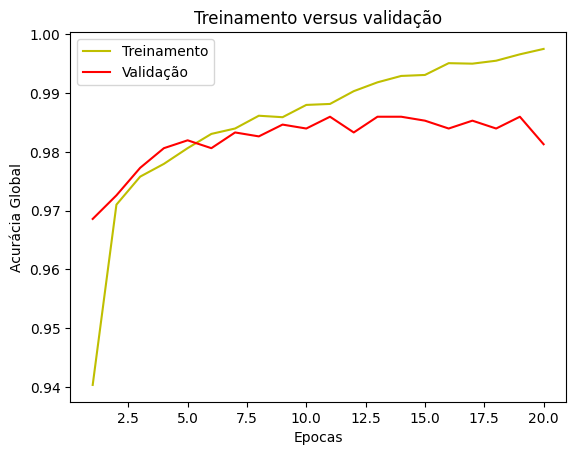

In [ ]:
#plotar gráficos
import matplotlib.pyplot as plt

loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs = range(1, len(loss)+ 1)

plt.plot(epochs, loss, 'y', label = "Treinamento")
plt.plot(epochs, val_loss, 'r', label = "Validação")

plt.title("Treinamento versus validação")
plt.xlabel("Epocas")
plt.ylabel("Acurácia Global")
plt.legend()
plt.show()

In [ ]:
model.save('malaria_K3.h5')

In [ ]:
from keras.models import load_model

model = load_model('malaria_K3.h5')

In [ ]:
score = model.evaluate(X_test_p, Y_test_p)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

47/47 [==============================] - 2s 39ms/step - loss: 0.0619 - accuracy: 0.9846
Test loss: 0.061920762062072754
Test accuracy: 0.9846359491348267
